In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics, model_selection
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,log_loss, roc_curve
import joblib

In [2]:
train_org = pd.read_csv("aug_train.csv")
train_org.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [3]:
train_org.shape

(19158, 14)

In [4]:
train_org.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [5]:
train_org.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [6]:
train_org.target.value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

In [7]:
train = train_org.dropna(thresh=11)

In [8]:
train.shape

(18280, 14)

In [9]:
for col in train.columns:
    if train[col].isna().sum()!=0:
        train[col].fillna('unknown',inplace=True)
        print(col,len(train[train[col]=='unknown'])*100/len(train))
        a = train[train[col]=='unknown'].groupby('target').aggregate({col:'count'})
        print(a[col]*100/sum(a[col]))
        print('\n')

gender 20.919037199124727
target
0.0    69.482218
1.0    30.517782
Name: gender, dtype: float64


enrolled_university 1.1159737417943107
target
0.0    62.254902
1.0    37.745098
Name: enrolled_university, dtype: float64


education_level 0.8041575492341356
target
0.0    78.911565
1.0    21.088435
Name: education_level, dtype: float64


major_discipline 11.291028446389497
target
0.0    82.751938
1.0    17.248062
Name: major_discipline, dtype: float64


experience 0.18052516411378555
target
0.0    63.636364
1.0    36.363636
Name: experience, dtype: float64


company_size 27.87199124726477
target
0.0    57.526987
1.0    42.473013
Name: company_size, dtype: float64


company_type 28.938730853391686
target
0.0    59.621928
1.0    40.378072
Name: company_type, dtype: float64


last_new_job 1.2472647702407003
target
0.0    64.912281
1.0    35.087719
Name: last_new_job, dtype: float64




C:\Users\karan\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [10]:
train.drop('enrollee_id',axis=1, inplace=True)

C:\Users\karan\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Text(0.5, 1.0, 'Distribution of the Gender variable')

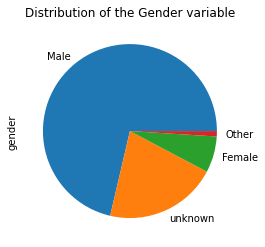

In [34]:
train['gender'].value_counts().plot(kind='pie')
plt.title('Distribution of the Gender variable')

Text(0.5, 1.0, 'Distribution of relevent_experience')

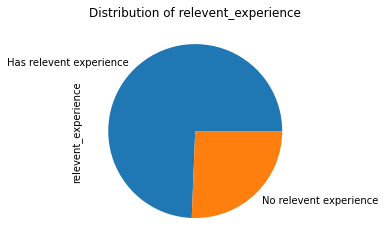

In [38]:
train['relevent_experience'].value_counts().plot(kind='pie')
plt.title('Distribution of relevent_experience')

Text(0.5, 1.0, 'Bar Chart - Enrolled University')

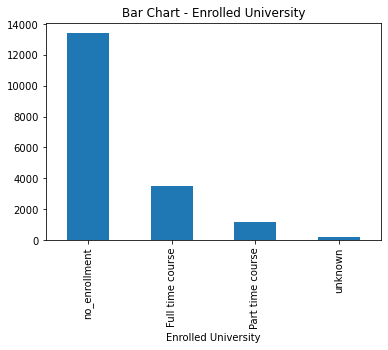

In [40]:
train['enrolled_university'].value_counts().plot(kind='bar')
plt.xlabel('Enrolled University')
plt.title('Bar Chart - Enrolled University')

<AxesSubplot:ylabel='education_level'>

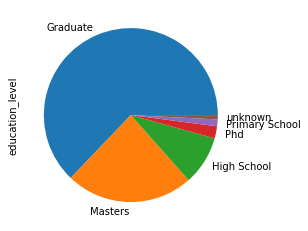

In [14]:
train['education_level'].value_counts().plot(kind='pie')

Text(0.5, 1.0, 'Bar Chart - Company Type')

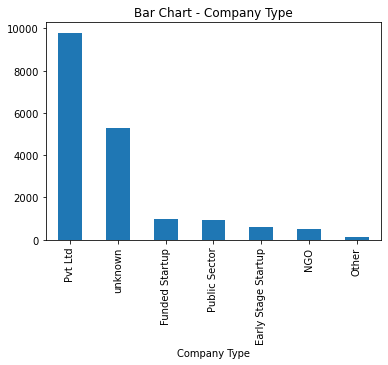

In [41]:
train['company_type'].value_counts().plot(kind='bar')
plt.xlabel('Company Type')
plt.title('Bar Chart - Company Type')

<AxesSubplot:>

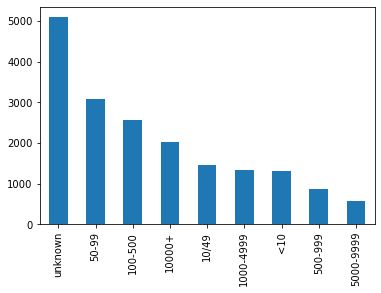

In [16]:
train['company_size'].value_counts().plot(kind='bar')

336

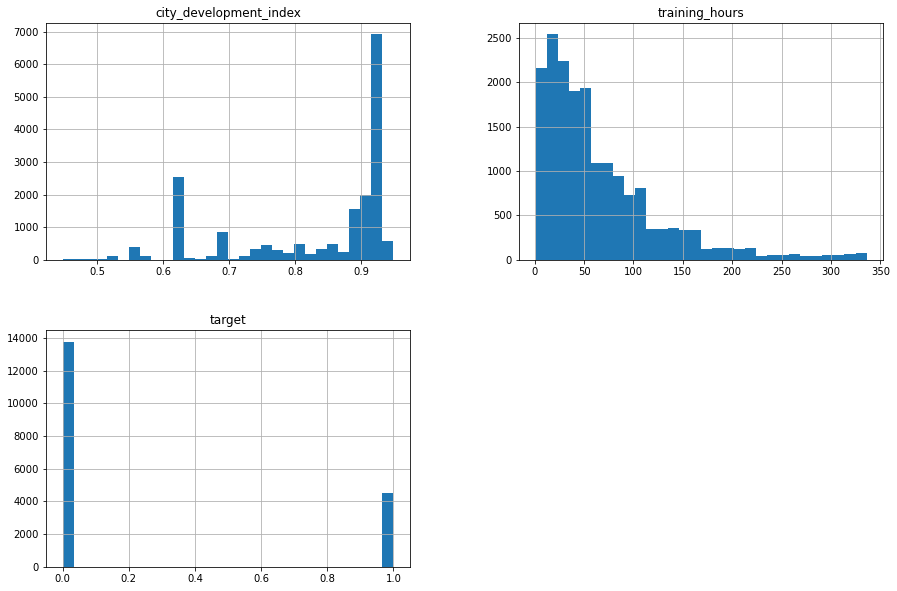

In [17]:
train.hist(bins=30,figsize=(15,10))
plt.show()

Text(0.5, 1.0, 'Correlation Matrix')

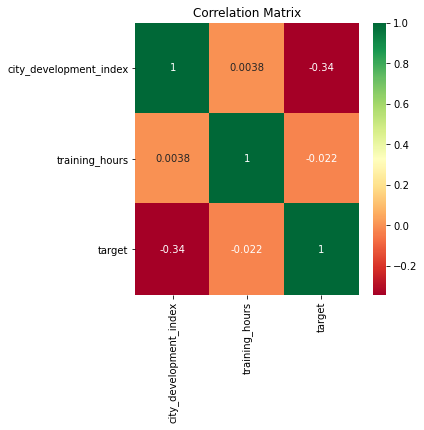

In [42]:
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(5,5))
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.title('Correlation Matrix')

In [19]:
clean_train = train.copy()

In [20]:
def scaling(df):
    numerical_cols = []
    scaler= MinMaxScaler()
    for col in df.columns:
        if col != 'target':
            if df.dtypes[col] != 'object':
                numerical_cols.append(col) 
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    joblib.dump(scaler,'min_max.pkl')
    return df

In [21]:
#scaled_train = scaling(clean_train)

In [22]:
def encoding(df):
    categorical_cols = []
    for col in df.columns:
        if df.dtypes[col] == 'object':
            categorical_cols.append(col)
    encoded_train = pd.get_dummies(df, columns=categorical_cols)
    return encoded_train

In [23]:
encoded_train = encoding(clean_train)
encoded_train_pca = encoding(clean_train)

In [24]:
features=[ i for i in encoded_train.columns if i!='target']
X=encoded_train[features]
Y=encoded_train['target']

In [25]:
city_columns=[]
non_city_columns=[]
for i in encoded_train_pca.columns:
    if 'city_city' in i:
        city_columns.append(i)
    else:
        non_city_columns.append(i)

In [26]:
pca=PCA(n_components=0.85)
pca.fit(encoded_train_pca[city_columns])

print(pca.explained_variance_ratio_.sum())
print(pca.n_components_)

pca_columns=pca.transform(encoded_train_pca[city_columns])

temp_df=pd.DataFrame(pca_columns)
temp_df.head()

0.8527405207143354
33


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.777954,0.142997,0.022538,0.041032,0.018810,0.008210,0.004343,1.511807e-16,-0.000661,0.001256,...,0.000161,0.000292,0.000228,0.000164,0.000260,-2.414176e-17,-0.000436,0.000165,-0.000286,0.000199
1,-0.146598,-0.143373,-0.048785,-0.129886,-0.098756,-0.067068,-0.049991,-4.123178e-15,0.011557,-0.023201,...,-0.011336,-0.021699,-0.018149,-0.013753,-0.023215,2.240540e-15,0.045970,-0.019483,0.036933,-0.028563
2,-0.502899,0.739508,0.055026,0.087567,0.036226,0.015017,0.007740,4.634309e-16,-0.001154,0.002187,...,0.000272,0.000495,0.000387,0.000277,0.000440,-3.108066e-17,-0.000735,0.000279,-0.000482,0.000336
3,-0.146139,-0.142618,-0.048380,-0.128471,-0.097150,-0.065480,-0.048390,-4.048585e-15,0.011019,-0.022065,...,-0.009534,-0.018097,-0.014966,-0.011232,-0.018746,2.007219e-15,0.035865,-0.014826,0.027472,-0.020672
4,-0.148852,-0.147127,-0.050834,-0.137165,-0.107300,-0.075939,-0.059471,-4.827476e-15,0.015117,-0.030857,...,-0.127401,-0.531112,0.729895,0.168517,0.156375,-1.064672e-14,-0.128577,0.037937,-0.056010,0.034032


In [27]:
encoded_train_pca[non_city_columns].reset_index()
encoded_train_pca=pd.concat([encoded_train_pca[non_city_columns].reset_index(),temp_df],axis=1).drop(columns=['index'])

In [28]:
encoded_train_pca.head()

,city_development_index,training_hours,target,gender_Female,gender_Male,gender_Other,gender_unknown,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,enrolled_university_Full time course,...,23,24,25,26,27,28,29,30,31,32
0,0.920,36,1.0,0,1,0,0,1,0,0,...,0.000161,0.000292,0.000228,0.000164,0.000260,-2.414176e-17,-0.000436,0.000165,-0.000286,0.000199
1,0.776,47,0.0,0,1,0,0,0,1,0,...,-0.011336,-0.021699,-0.018149,-0.013753,-0.023215,2.240540e-15,0.045970,-0.019483,0.036933,-0.028563
2,0.624,83,0.0,0,0,0,1,0,1,1,...,0.000272,0.000495,0.000387,0.000277,0.000440,-3.108066e-17,-0.000735,0.000279,-0.000482,0.000336
3,0.789,52,1.0,0,0,0,1,0,1,0,...,-0.009534,-0.018097,-0.014966,-0.011232,-0.018746,2.007219e-15,0.035865,-0.014826,0.027472,-0.020672
4,0.767,8,0.0,0,1,0,0,1,0,0,...,-0.127401,-0.531112,0.729895,0.168517,0.156375,-1.064672e-14,-0.128577,0.037937,-0.056010,0.034032


In [29]:
encoded_train_pca=scaling(encoded_train_pca)

In [30]:
features_pca=[ i for i in encoded_train_pca.columns if i!='target']
X_pca=encoded_train_pca[features_pca]
Y_pca=encoded_train_pca['target']

In [31]:
X_pca.head()

,city_development_index,training_hours,gender_Female,gender_Male,gender_Other,gender_unknown,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,enrolled_university_Full time course,enrolled_university_Part time course,...,23,24,25,26,27,28,29,30,31,32
0,0.942116,0.104478,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.411752,0.435828,0.428813,0.499640,0.463011,0.5,0.379735,0.491676,0.484584,0.395028
1,0.654691,0.137313,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.403308,0.417792,0.414426,0.489315,0.441221,0.5,0.428479,0.477280,0.516106,0.369978
2,0.351297,0.244776,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.411834,0.435994,0.428936,0.499724,0.463178,0.5,0.379420,0.491759,0.484417,0.395147
3,0.680639,0.152239,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.404632,0.420746,0.416918,0.491185,0.445369,0.5,0.417865,0.480692,0.508093,0.376851
4,0.636727,0.020896,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.318065,0.000000,1.000000,0.624548,0.607923,0.5,0.245137,0.519351,0.437387,0.424495


                                           Specs     Score
1                                 training_hours  0.153755
66                                  city_city_21  0.067196
0                         city_development_index  0.061722
179                         company_size_unknown  0.033787
186                         company_type_unknown  0.024908
187                               last_new_job_1  0.019589
185                         company_type_Pvt Ltd  0.016957
188                               last_new_job_2  0.015178
126                                  gender_Male  0.015134
7                                  city_city_103  0.015054
135                     education_level_Graduate  0.014695
128                               gender_unknown  0.013881
133            enrolled_university_no_enrollment  0.013760
163                                 experience_5  0.012269
175                           company_size_50-99  0.012232
162                                 experience_4  0.0116

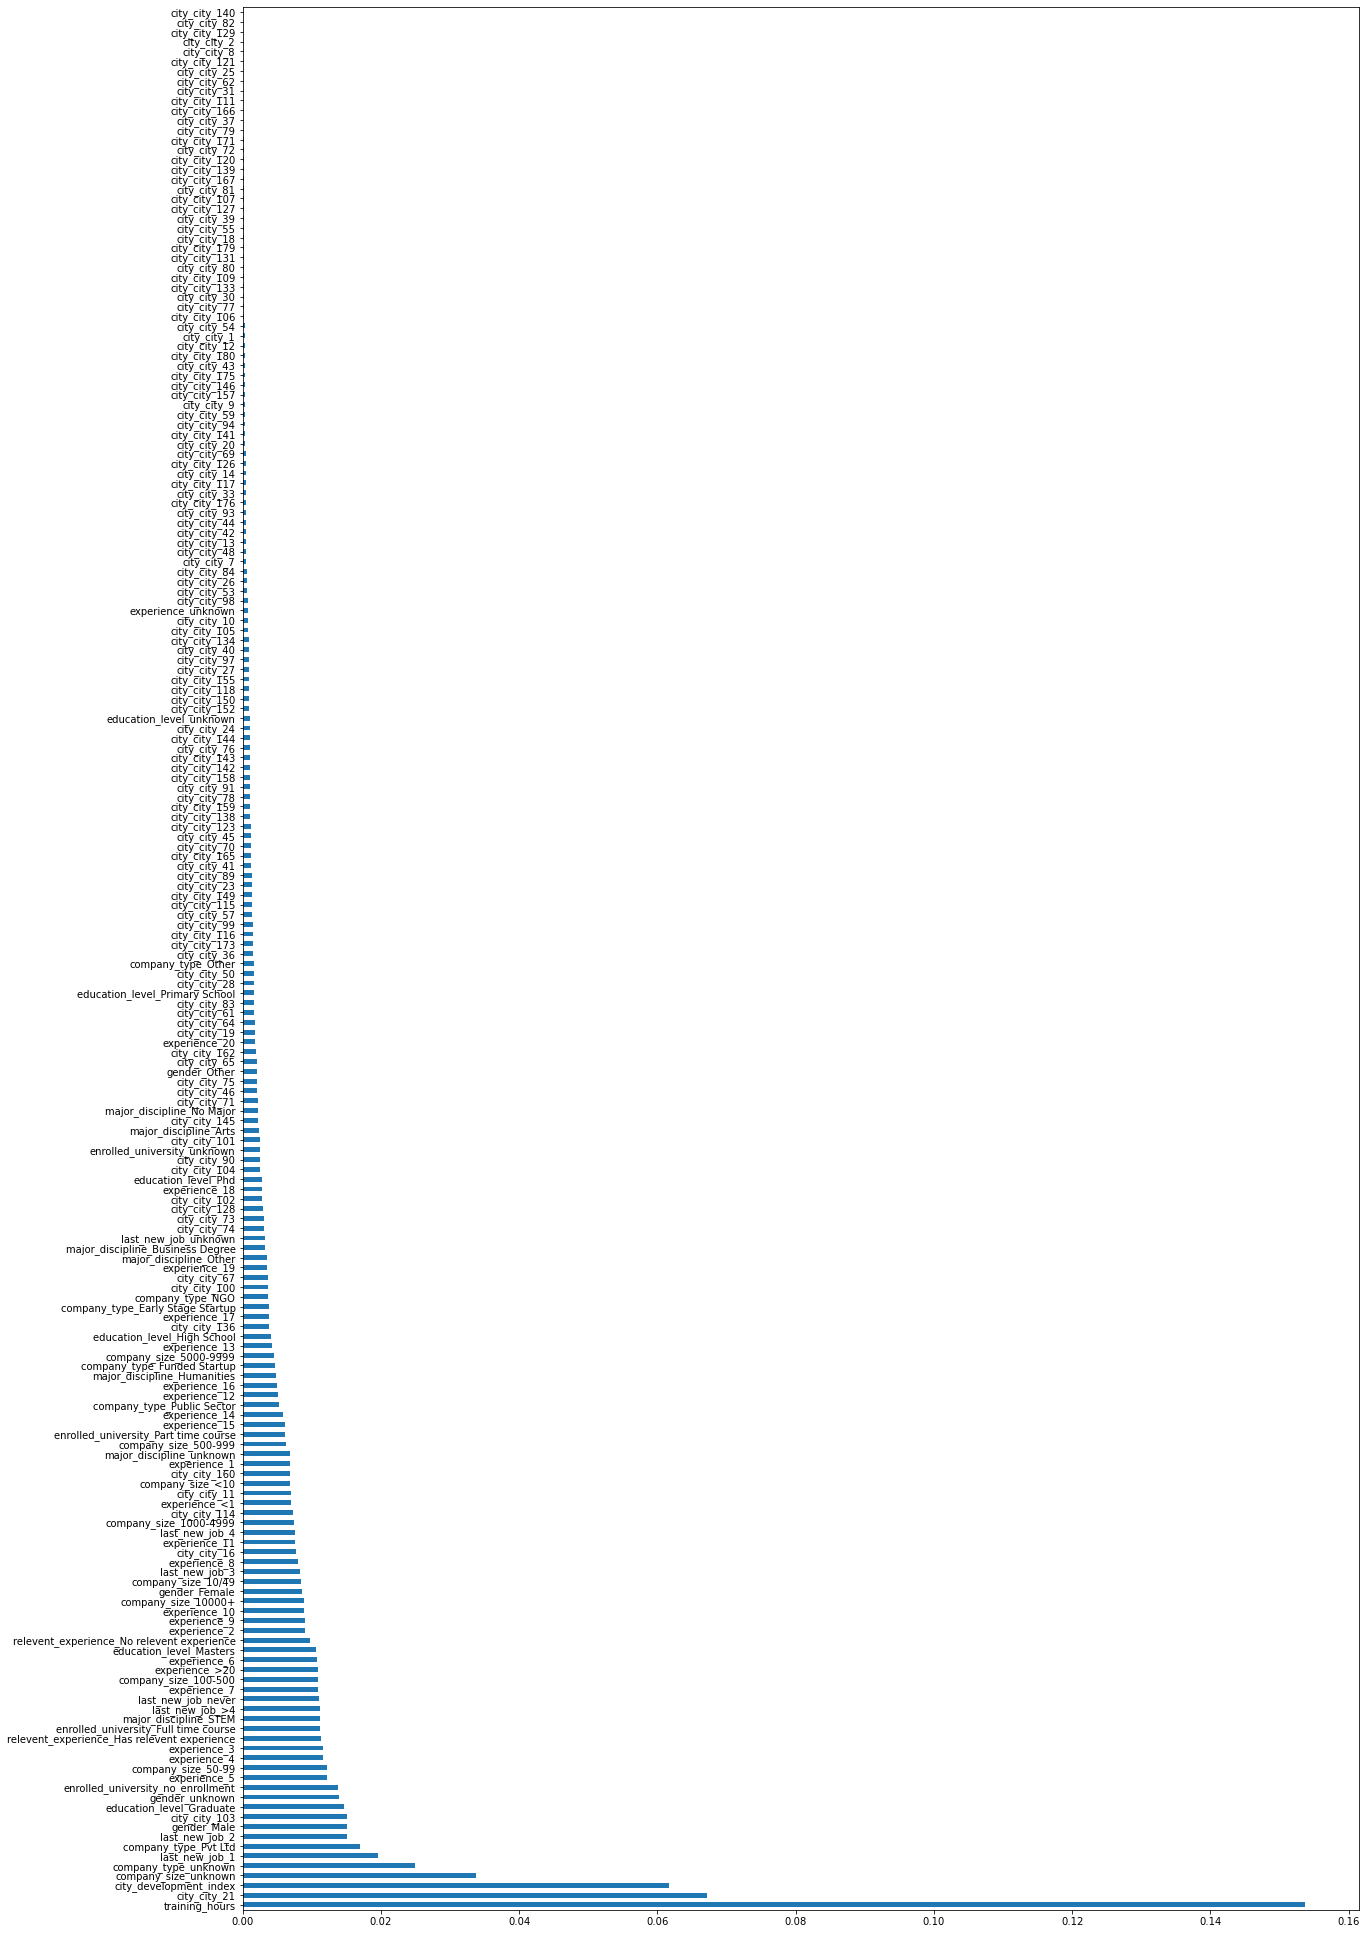

In [33]:
bestfeatures = ExtraTreesClassifier(n_estimators=100)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.feature_importances_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(30,'Score'))

feat_importances = pd.Series(fit.feature_importances_, index=X.columns)
feat_importances.nlargest(195).plot(kind='barh',figsize=(20,35))
plt.show()

                                          Specs     Score
1                                training_hours  0.148377
72                                            1  0.042318
56                         company_size_unknown  0.035810
63                         company_type_unknown  0.022360
71                                            0  0.022331
0                        city_development_index  0.021822
64                               last_new_job_1  0.021283
62                         company_type_Pvt Ltd  0.018855
73                                            2  0.017851
74                                            3  0.016650
3                                   gender_Male  0.015453
65                               last_new_job_2  0.015140
12                     education_level_Graduate  0.014967
10            enrolled_university_no_enrollment  0.013545
5                                gender_unknown  0.013348
40                                 experience_5  0.013100
39            

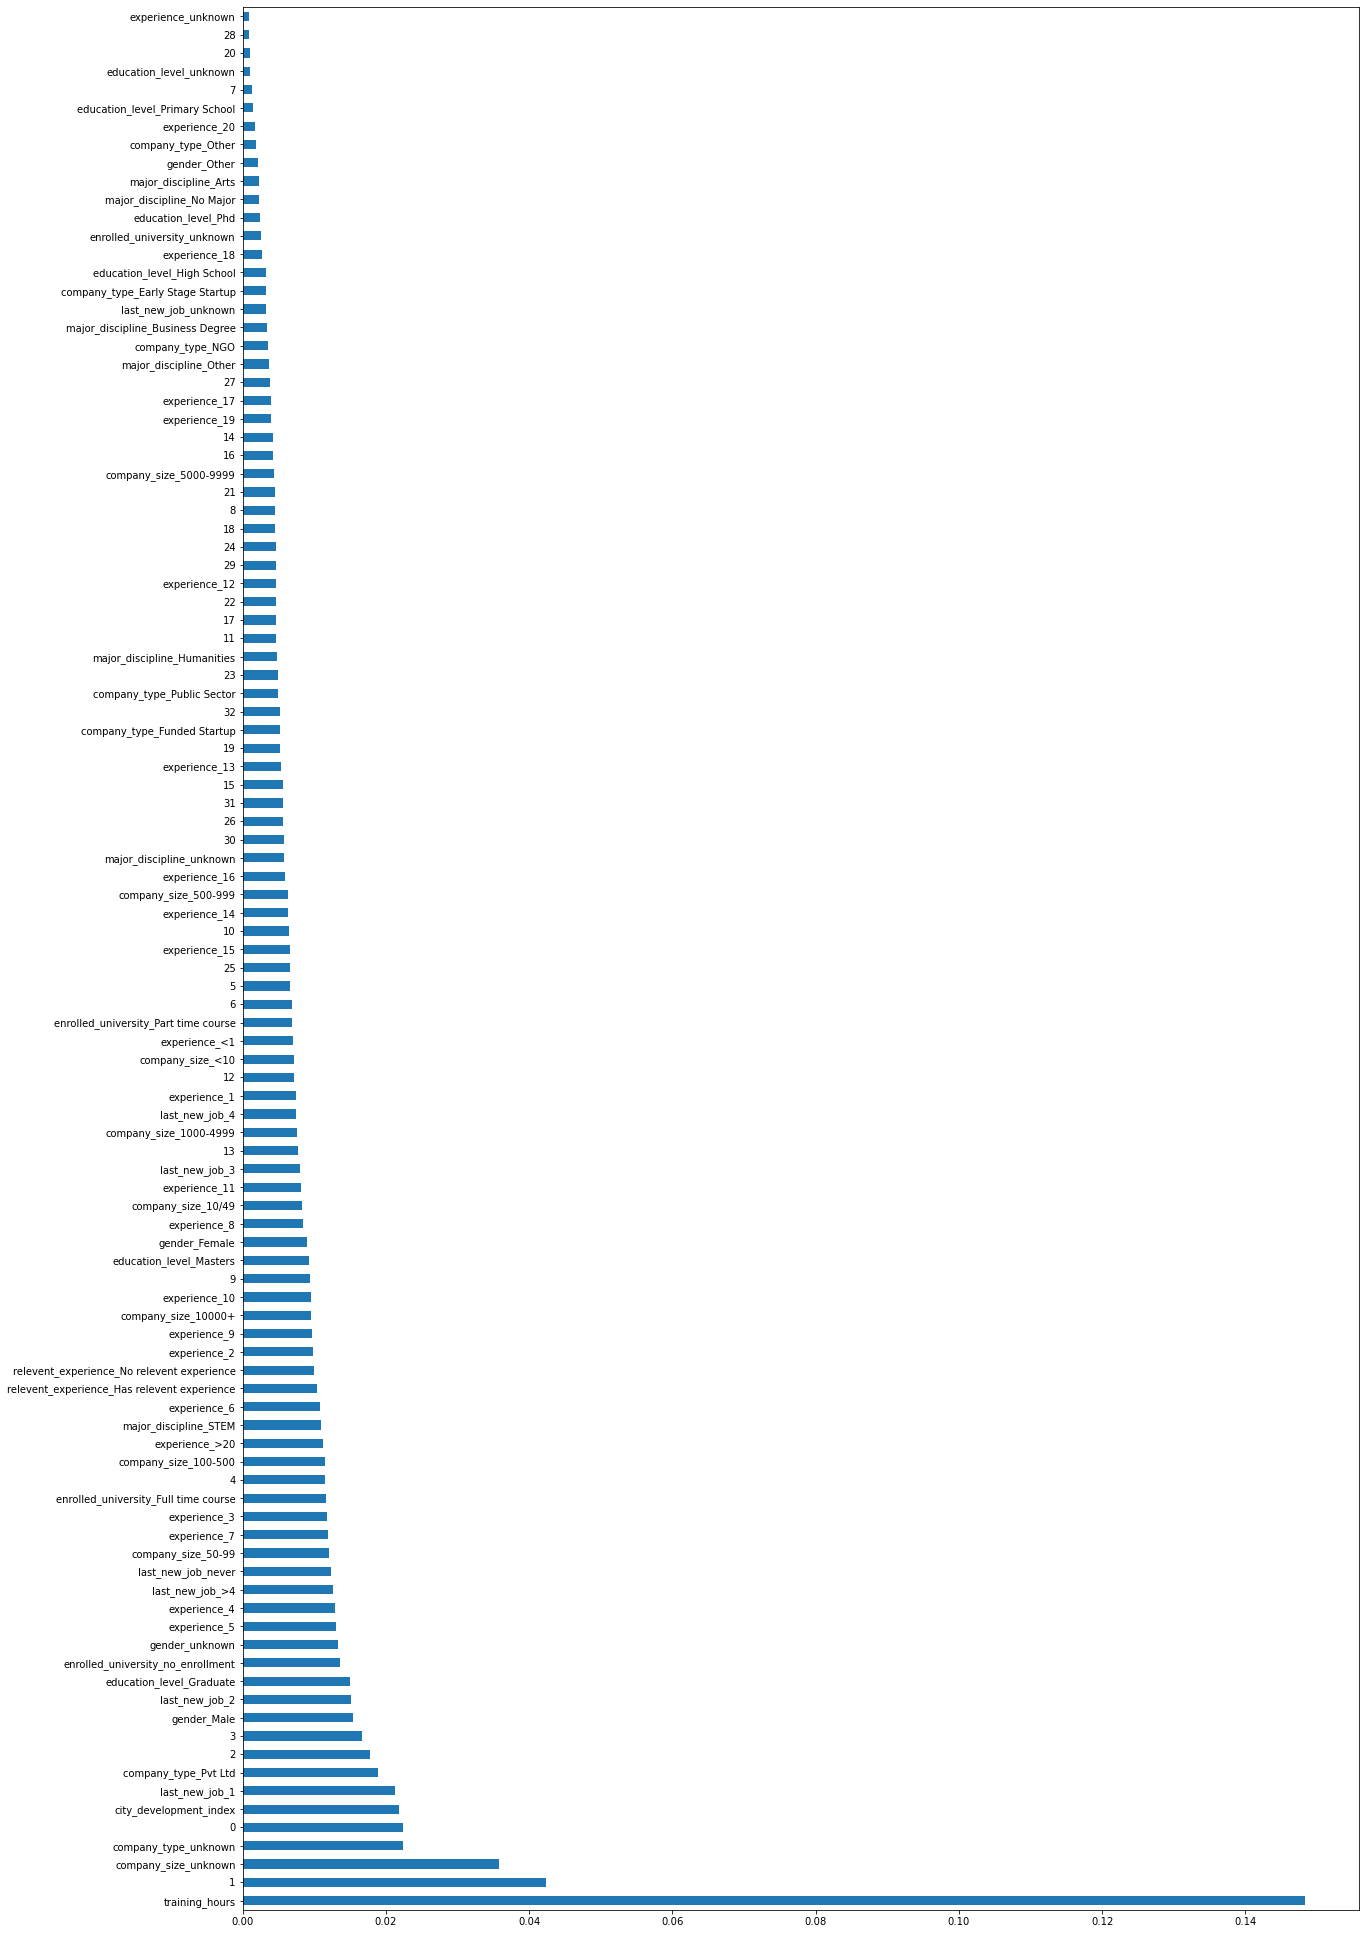

In [41]:
bestfeatures_pca = ExtraTreesClassifier(n_estimators=10)
fit_pca = bestfeatures_pca.fit(X_pca,Y_pca)
dfscores = pd.DataFrame(fit_pca.feature_importances_)
dfcolumns = pd.DataFrame(X_pca.columns)
featureScores_pca = pd.concat([dfcolumns,dfscores],axis=1)
featureScores_pca.columns = ['Specs','Score']  
print(featureScores_pca.nlargest(30,'Score'))

feat_importances_pca = pd.Series(fit_pca.feature_importances_, index=X_pca.columns)
feat_importances_pca.nlargest(104).plot(kind='barh',figsize=(20,35))
plt.show()

In [44]:
def models(features,target):
    scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

    kfold = model_selection.StratifiedKFold(n_splits=5)

    model = {'Logistic Regression': LogisticRegression(max_iter = 1000, solver='lbfgs'),
             'Random Forest': RandomForestClassifier(),
             'Gradient Boosting': GradientBoostingClassifier(),
             'Support Vector Machine': SVC(gamma='auto')}
    
    for i in model:
        score = model_selection.cross_validate(model[i], features, target, scoring=scoring,cv=kfold)
        print(i)
        score.pop('fit_time')
        score.pop('score_time')
        for j in score:
            print(j, round(sum(score[j])*100/len(score[j]),2))

In [45]:
models(X,Y)

Logistic Regression
test_accuracy 78.48
test_precision 60.29
test_recall 38.16
test_f1_score 46.72
Random Forest
test_accuracy 78.47
test_precision 58.04
test_recall 46.7
test_f1_score 51.74
Gradient Boosting
test_accuracy 79.76
test_precision 59.94
test_recall 54.87
test_f1_score 57.27
Support Vector Machine
test_accuracy 77.88
test_precision 59.44
test_recall 33.42
test_f1_score 42.76


In [46]:
models(X_pca,Y_pca)

Logistic Regression
test_accuracy 78.45
test_precision 60.26
test_recall 37.78
test_f1_score 46.44
Random Forest
test_accuracy 78.71
test_precision 58.41
test_recall 48.3
test_f1_score 52.85
Gradient Boosting
test_accuracy 79.72
test_precision 59.72
test_recall 55.47
test_f1_score 57.49
Support Vector Machine
test_accuracy 77.88
test_precision 59.44
test_recall 33.42
test_f1_score 42.76


In [48]:
X_A = feat_importances_pca.nlargest(50).index.to_list()

In [49]:
models(X_pca[X_A],Y_pca)

Logistic Regression
test_accuracy 78.53
test_precision 60.74
test_recall 37.27
test_f1_score 46.18
Random Forest
test_accuracy 78.15
test_precision 57.13
test_recall 46.59
test_f1_score 51.32
Gradient Boosting
test_accuracy 79.51
test_precision 59.4
test_recall 54.25
test_f1_score 56.69
Support Vector Machine
test_accuracy 77.92
test_precision 59.2
test_recall 34.57
test_f1_score 43.62


In [50]:
# Create hyperparameter options
log_hp = {'C':[0.01,0.05,0.1,0.5,0.8,1,2,5,10,20],
          'penalty': ['l2'],
          'max_iter':[1000]}
rf_hp = {'n_estimators': [100], 
         'criterion': ['gini', 'entropy'],              
         'min_samples_split': [2,4,6,8],
         'min_samples_leaf':[5,10,15,20]}
gb_hp = {"learning_rate": [0.1, 0.15, 0.2],
         'min_samples_split': [2,4],
         'min_samples_leaf':[2,5],
         "n_estimators":[100]}
svm_hp = {'kernel':('poly','rbf'), 'C':[0.5,1,2,5,10]}

def grid_model(algo,params,features,target):
    kfold = model_selection.StratifiedKFold(n_splits=5)
    scoring = ['accuracy','precision','recall','f1']
    
    clf = GridSearchCV(estimator=algo, param_grid=params, cv=kfold, verbose=0, scoring=scoring, refit='accuracy')
    best_model = clf.fit(features,target)
    
    print('Params:', best_model.best_estimator_.get_params())
    print('accuracy',best_model.best_score_*100)
    print('precision',sum(best_model.cv_results_['mean_test_precision'])*100/len(best_model.cv_results_['mean_test_precision']))
    print('recall',sum(best_model.cv_results_['mean_test_recall'])*100/len(best_model.cv_results_['mean_test_recall']))
    print('f1',sum(best_model.cv_results_['mean_test_f1'])*100/len(best_model.cv_results_['mean_test_f1']))
    return best_model

In [51]:
grid_model(LogisticRegression(),log_hp,X_pca,Y_pca)

Params: {'C': 5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
accuracy 78.47374179431073
precision 60.37473933650515
recall 35.624278462156624
f1 44.59037015349718


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 2, 5, 10, 20],
                         'max_iter': [1000], 'penalty': ['l2']},
             refit='accuracy',
             scoring=['accuracy', 'precision', 'recall', 'f1'])

In [52]:
grid_model(RandomForestClassifier(),rf_hp,X_pca,Y_pca)

Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 10, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
accuracy 79.9945295404814
precision 59.79880144350278
recall 55.609588460049586
f1 57.607064610997064


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [100]},
             refit='accuracy',
             scoring=['accuracy', 'precision', 'recall', 'f1'])

In [53]:
grid_model(GradientBoostingClassifier(),gb_hp,X_pca,Y_pca)

Params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
accuracy 79.83588621444201
precision 59.833743448720014
recall 55.05944214140346
f1 57.32158419988527


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.15, 0.2],
                         'min_samples_leaf': [2, 5],
                         'min_samples_split': [2, 4], 'n_estimators': [100]},
             refit='accuracy',
             scoring=['accuracy', 'precision', 'recall', 'f1'])

In [54]:
grid_model(SVC(),svm_hp,X_pca,Y_pca)

Params: {'C': 2, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
accuracy 79.67724288840262
precision 58.46342050160323
recall 54.090560961985126
f1 56.14297567520305


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(),
             param_grid={'C': [0.5, 1, 2, 5, 10], 'kernel': ('poly', 'rbf')},
             refit='accuracy',
             scoring=['accuracy', 'precision', 'recall', 'f1'])

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y_pca, test_size=0.2, random_state=42,stratify=Y_pca)

In [249]:
len(X_train)

14624

In [250]:
len(X_test)

3656

In [251]:
(y_train.value_counts())/len(y_train)

0.0    0.752872
1.0    0.247128
Name: target, dtype: float64

In [252]:
(y_test.value_counts())/len(y_test)

0.0    0.752735
1.0    0.247265
Name: target, dtype: float64

In [253]:
log_model=LogisticRegression(max_iter=1000,solver='lbfgs',C=5,penalty='l2')
log_model.fit(X_train,y_train)
log=log_model.predict_proba(X_test)[:,0]
log_prediction=log_model.predict(X_test)

rf_model=RandomForestClassifier(n_estimators=100,min_samples_leaf=10,min_samples_split=6,criterion='entropy')
rf_model.fit(X_train,y_train)
rf=rf_model.predict_proba(X_test)[:,0]
rf_prediction=rf_model.predict(X_test)

gb_model=GradientBoostingClassifier(learning_rate=0.1,min_samples_leaf=2,min_samples_split=2,n_estimators=100)
gb_model.fit(X_train,y_train)
gb=gb_model.predict_proba(X_test)[:,0]
gb_prediction=gb_model.predict(X_test)


svc_model=SVC(C=2,kernel='rbf',gamma='scale',probability=True)
svc_model.fit(X_train,y_train)
svc=svc_model.predict_proba(X_test)[:,0]
svc_prediction=svc_model.predict(X_test)

In [254]:
print('Logistic Regression - Classification Report \n')
print(confusion_matrix(y_test,log_prediction))
print(classification_report(y_test,log_prediction))
print('LogLoss',log_loss(y_test,log_model.predict_proba(X_test)))
print('Area Under ROC Curve',metrics.roc_auc_score(y_test,log_prediction))

Logistic Regression - Classification Report 

[[2529  223]
 [ 556  348]]
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87      2752
         1.0       0.61      0.38      0.47       904

    accuracy                           0.79      3656
   macro avg       0.71      0.65      0.67      3656
weighted avg       0.77      0.79      0.77      3656

LogLoss 0.4531536465796247
Area Under ROC Curve 0.6519618877341017


In [255]:
print('Random Forest - Classification Report \n')
print(confusion_matrix(y_test,rf_prediction))
print(classification_report(y_test,rf_prediction))
print('LogLoss',log_loss(y_test,rf_model.predict_proba(X_test)))
print('Area Under ROC Curve',metrics.roc_auc_score(y_test,rf_prediction))

Random Forest - Classification Report 

[[2400  352]
 [ 406  498]]
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.86      2752
         1.0       0.59      0.55      0.57       904

    accuracy                           0.79      3656
   macro avg       0.72      0.71      0.72      3656
weighted avg       0.79      0.79      0.79      3656

LogLoss 0.4443743935619855
Area Under ROC Curve 0.7114889895040132


In [256]:
print('Gradient Boost - Classification Report \n')
print(confusion_matrix(y_test,gb_prediction))
print(classification_report(y_test,gb_prediction))
print('LogLoss',log_loss(y_test,gb_model.predict_proba(X_test)))
print('Area Under ROC Curve',metrics.roc_auc_score(y_test,gb_prediction))

Gradient Boost - Classification Report 

[[2422  330]
 [ 414  490]]
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87      2752
         1.0       0.60      0.54      0.57       904

    accuracy                           0.80      3656
   macro avg       0.73      0.71      0.72      3656
weighted avg       0.79      0.80      0.79      3656

LogLoss 0.439375187732192
Area Under ROC Curve 0.711061303766207


In [257]:
print('SVM - Classification Report \n')
print(confusion_matrix(y_test,svc_prediction))
print(classification_report(y_test,svc_prediction))
print('LogLoss',log_loss(y_test,svc_model.predict_proba(X_test)))
print('Area Under ROC Curve',metrics.roc_auc_score(y_test,svc_prediction))

SVM - Classification Report 

[[2401  351]
 [ 413  491]]
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      2752
         1.0       0.58      0.54      0.56       904

    accuracy                           0.79      3656
   macro avg       0.72      0.71      0.71      3656
weighted avg       0.79      0.79      0.79      3656

LogLoss 0.4591735311238594
Area Under ROC Curve 0.7077989941345957


In [258]:
ensemble = pd.DataFrame({'actual':y_test,'log_pred':log,'rf_pred':rf,'gb_pred':gb,'svc_pred':svc})
ensemble['avg']=(ensemble['log_pred']+ensemble['rf_pred']+ensemble['gb_pred']+ensemble['svc_pred'])/4

In [259]:
#Default Ensemble

In [260]:
ensemble['pred']=np.where(ensemble['avg'] >= 0.50, 0, 1) 
ensemble['avg_1']=1-ensemble['avg']
avg_arr=[]
for i in range(len(ensemble)):
    avg_arr.append([ensemble['avg'].iloc[i],ensemble['avg_1'].iloc[i]])
print(confusion_matrix(ensemble['actual'],ensemble['pred'],labels=[0,1]))
print(classification_report(ensemble['actual'],ensemble['pred'],labels=[0,1]))
print('LogLoss',log_loss(ensemble['actual'],avg_arr,labels=[0,1]))
print('Area Under ROC Curve',metrics.roc_auc_score(ensemble['actual'],ensemble['pred'],labels=[0,1]))

[[2440  312]
 [ 445  459]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2752
           1       0.60      0.51      0.55       904

    accuracy                           0.79      3656
   macro avg       0.72      0.70      0.71      3656
weighted avg       0.78      0.79      0.79      3656

LogLoss 0.44088492730675233
Area Under ROC Curve 0.6971856349043013


In [261]:
ensemble

,actual,log_pred,rf_pred,gb_pred,svc_pred,avg,pred,avg_1
6432,0.0,0.853241,0.805101,0.802104,0.839404,0.824963,0,0.175037
3294,0.0,0.899474,0.861713,0.904416,0.854132,0.879934,0,0.120066
1846,0.0,0.860407,0.899106,0.906622,0.865091,0.882807,0,0.117193
12648,0.0,0.812562,0.915845,0.915767,0.902988,0.886790,0,0.113210
2481,0.0,0.845125,0.815439,0.839707,0.930013,0.857571,0,0.142429
...,...,...,...,...,...,...,...,...
14005,0.0,0.697216,0.650354,0.712230,0.856593,0.729098,0,0.270902
5838,0.0,0.883772,0.919033,0.916803,0.865273,0.896220,0,0.103780
2453,0.0,0.871744,0.958510,0.938342,0.894061,0.915664,0,0.084336
12992,0.0,0.911001,0.928499,0.929946,0.901475,0.917730,0,0.082270


In [262]:
#Finding Optimum Threshold

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, test_ensemble['average'])
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

In [267]:
ensemble['pred']=np.where(ensemble['avg'] >= best_thresh, 0, 1) 

print(confusion_matrix(ensemble['actual'],ensemble['pred'],labels=[0,1]))
print(classification_report(ensemble['actual'],ensemble['pred'],labels=[0,1]))

[[2213  539]
 [ 246  658]]
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      2752
           1       0.55      0.73      0.63       904

    accuracy                           0.79      3656
   macro avg       0.72      0.77      0.74      3656
weighted avg       0.81      0.79      0.79      3656

